In [2]:
import pathlib
from src.models.cmu_mosei_module import CmuMoseiModule
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "best_models" / "best_trimodal_model.ckpt"
best_trimodal_model_checkpoint = str(data_folder)

device = torch.device("cpu" if torch.cpu.is_available() else "mps")
model = CmuMoseiModule.load_from_checkpoint(best_trimodal_model_checkpoint).to(device)
model.eval()


CmuMoseiModule(
  (model): EmotionClassifier(
    (embedding_creator): TrimodalEmotionEmbeddingCreator(
      (text_model): GloveEmotionEmbeddingCreator(
        (convs): ModuleList(
          (0): Conv2d(1, 50, kernel_size=(3, 300), stride=(1, 1))
          (1): Conv2d(1, 50, kernel_size=(4, 300), stride=(1, 1))
          (2): Conv2d(1, 50, kernel_size=(5, 300), stride=(1, 1))
        )
      )
      (video_model): AudioVideoEmotionEmbeddingCreator(
        (cnn): Sequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU()
          (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): ReLU()
          (4): AdaptiveMaxPool1d(output_size=1)
        )
        (lstm): LSTM(64, 128, batch_first=True)
      )
      (audio_model): AudioVideoEmotionEmbeddingCreator(
        (cnn): Sequential(
          (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU()
          (2): Conv1d(64, 64, ke

In [2]:
import torch

notebook_folder = pathlib.Path().resolve()
project_folder = notebook_folder.parent
data_folder = project_folder / "data" / "aligned_covarep_data"
val_data_file = data_folder / "val_data.pkl"
val_labels_file = data_folder / "val_labels.pkl"
test_data_file = data_folder / "test_data.pkl"
test_labels_file = data_folder / "test_labels.pkl"
with open(val_data_file, "rb") as f:
    audio_val_features = torch.load(f)
with open(val_labels_file, "rb") as f:
    val_labels = torch.load(f)
with open(test_data_file, "rb") as f:
    audio_test_features = torch.load(f)
with open(test_labels_file, "rb") as f:
    test_labels = torch.load(f)

data_folder = project_folder / "data" / "aligned_open_face_data"
val_data_file = data_folder / "val_data.pkl"
with open(val_data_file, "rb") as f:
    video_val_features = torch.load(f)

data_folder = project_folder / "data" / "aligned_glove_vectors_data"
val_data_file = data_folder / "val_data.pkl"
with open(val_data_file, "rb") as f:
    text_val_features = torch.load(f)

data_folder = project_folder / "data" / "aligned_open_face_data"
test_data_file = data_folder / "test_data.pkl"
with open(test_data_file, "rb") as f:
    video_test_features = torch.load(f)

data_folder = project_folder / "data" / "aligned_glove_vectors_data"
test_data_file = data_folder / "test_data.pkl"
with open(test_data_file, "rb") as f:
    text_test_features = torch.load(f)

In [3]:
from src.data.components.trimodal_dataset import TrimodalDataset
from torch.utils.data import DataLoader

val_dataset = TrimodalDataset(text_features=text_val_features, video_features=video_val_features, audio_features=audio_val_features, labels=val_labels)
test_dataset = TrimodalDataset(text_features=text_test_features, video_features=video_test_features, audio_features=audio_test_features, labels=test_labels)


val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=64)

In [63]:
all_predictions = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        _, predictions, labels = model.model_step(batch)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [4]:
all_test_predictions = []
all_test_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        _, predictions, labels = model.model_step(batch)
        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

<Figure size 800x600 with 0 Axes>

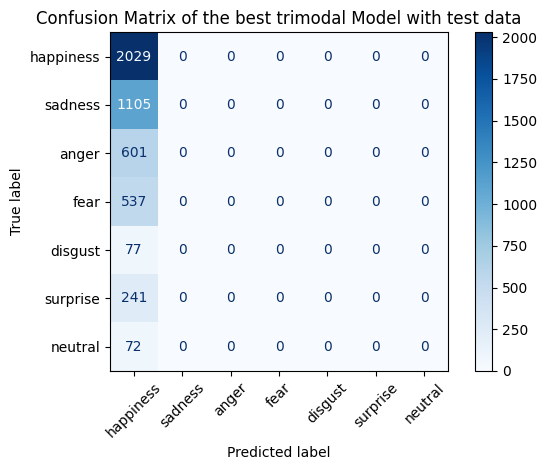

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["happiness", "sadness", "anger", "fear", "disgust", "surprise", "neutral"]  # replace as needed

cm = confusion_matrix(all_test_labels, all_test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix of the best trimodal model with test data")
plt.grid(False)
plt.tight_layout()
plt.show()